**Modflow-API** 

In [1]:
import datetime as dt ; import os  ; from pathlib import Path ; import flopy ; import matplotlib.pyplot as plt ; import modflowapi ; from modflowapi import Callbacks ; import shutil
import pandas as pd ; from flopy.plot import styles ; import pathlib as pl ; import matplotlib as mpl ; import pooch ;import pickle ; import numpy as np ; import csv 
TA=Path("./TA");TA.mkdir(exist_ok=True)  ; sim_ws = TA          ; model_name = "green_valley" ; sim_name = ID = "green_valley"

length_units = "feet" ; time_units = "seconds" ; nper = 2   ; nlay = 1  ; nrow = 15  ; ncol = 10  ; delr = 5000.0  ; delc = 5000.0  ; strt = 1050.0          #  (1.577880e9, 50, 1.1)
k11_stream = 0.002  ; k11_basin = 0.0004  ; ss = 1e-6  ; sy_stream = 0.2 ; sy_basin = 0.1  ; evap_rate = 9.5e-8  ; ext_depth = 15.0  ; tdis_ds = ((0.0, 1, 1.0),(1.577880e9, 50, 1.1),)
extents = (0.0, delr * ncol, 0.0, delc * nrow) ; shape2d = (nrow, ncol) ; shape3d = (nlay, nrow, ncol)      ; nouter = 100 ; ninner = 50 ; hclose = 1e-6 ; rclose = 1e-6

REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/11_ex-gwf-sfr-p01') ; idomain = np.loadtxt(REF1/"idomain.txt", dtype=int) ; top = np.loadtxt(REF1/"top.txt", dtype=float)
botm = np.loadtxt(REF1/"bottom.txt", dtype=float) ; recharge = np.loadtxt(REF1/"recharge.txt", dtype=float) ; surf = np.loadtxt(REF1/"surf.txt", dtype=float) 

k11 = np.zeros(shape2d, dtype=float) ; k11[idomain == 1] = k11_stream ; k11[idomain == 2] = k11_basin
sy = np.zeros(shape2d, dtype=float)  ; sy[idomain == 1] = sy_stream   ; sy[idomain == 2] = sy_basin

with open(REF1/ "e_ghb_spd    " ,'rb') as handle: GHB_S  = pickle.load(handle) 
with open(REF1/'Beta'/'WEL_S'   ,'rb') as handle: WEL_S = pickle.load(handle)     # with open(REF1/ "f_wel_spd    " ,'rb') as handle: WEL_S  = pickle.load(handle)
with open(REF1/ "c_sfr_div    " ,'rb') as handle: SFR_D  = pickle.load(handle)                                                                            #; SFR_D  
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')       ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()         #; SFR_C
SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).dropna(how='all').values.tolist()                                                          #; SFR_S
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).dropna(how='all')       ; SFR_P = df.to_records(index=False)                               #; SFR_P

In [2]:
def build_models(): 
    global OBS_D , OBS_F
    name = model_name
    sim = flopy.mf6.MFSimulation(sim_name=model_name, sim_ws=TA)         ; flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units ) ;aa="summary";bb="bicgstab"
    flopy.mf6.ModflowIms(sim,print_option=aa,linear_acceleration=bb,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict",)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=idomain,top=top,botm=botm,)
    flopy.mf6.ModflowGwfnpf(gwf,icelltype=1,k=k11,save_specific_discharge=True,)            ; flopy.mf6.ModflowGwfsto(gwf,iconvert=1,sy=sy,ss=ss,steady_state={0: True},transient={1: True},)
    flopy.mf6.ModflowGwfic(gwf, strt=strt)  ;     flopy.mf6.ModflowGwfghb(gwf, stress_period_data=GHB_S)       ; flopy.mf6.ModflowGwfwel(gwf, stress_period_data=WEL_S)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)                                                           ; flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=evap_rate, depth=ext_depth)
    sfr = flopy.mf6.ModflowGwfsfr(gwf,length_conversion=3.28081,nreaches=len(SFR_P),packagedata=SFR_P,connectiondata=SFR_C,diversions=SFR_D,perioddata=SFR_S,)
    OBS_F = f"{sim_name}.sfr.obs" ; csv_file = OBS_F + ".csv"
    OBS_D = {csv_file: [("r01_stage", "stage", (3,))           ,("r02_stage", "stage", (14,))           ,("r03_stage", "stage", (26,))           ,("r04_stage", "stage"          , (35,)),
                        ("r01_flow", "downstream-flow", (3,))  ,("r02_flow", "downstream-flow", (14,)) ,("r03_flow", "downstream-flow" ,(26,)) ,("r04_flow", "downstream-flow", (35,))]}
    sfr.obs.initialize(filename=OBS_F, digits=10, print_input=True, continuous=OBS_D)                ; HF = f"{name}.hds" ;     QF = f"{name}.cbc"
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=HF,budget_filerecord=QF,saverecord={0: [("HEAD", "LAST"), ("BUDGET", "LAST")],1: [("HEAD", "LAST"), ("BUDGET", "ALL")],},) ;     return sim

def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
def run_models(sim, silent=True):       success, buff = sim.run_simulation(silent=silent)       ;     assert success, buff

In [3]:
sim = build_models()             ; sim.write_simulation(silent=True)     ; sim.run_simulation(silent=True);

In [4]:
GWF=sim.get_model()             ; HOBJ=GWF.output.head()                              ; COBJ=GWF.output.budget()              ; kstpkper=HOBJ.get_kstpkper() 
SA =np.max(top)-np.min(top)     ; LT=np.arange(np.min(top[0]),np.max(top[0]), SA/60)  ; SB=np.max(botm)-np.min(botm)          ; LEV=np.arange(np.min(botm[0]), np.max(botm[0]), SB/10)    

Y0=0; head0 = HOBJ.get_data(kstpkper=kstpkper[Y0])    ;QX0,QY0,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y0])[0], GWF)
Y1=1; head1 = HOBJ.get_data(kstpkper=kstpkper[Y1])    ;QX1,QY1,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y1])[0], GWF)


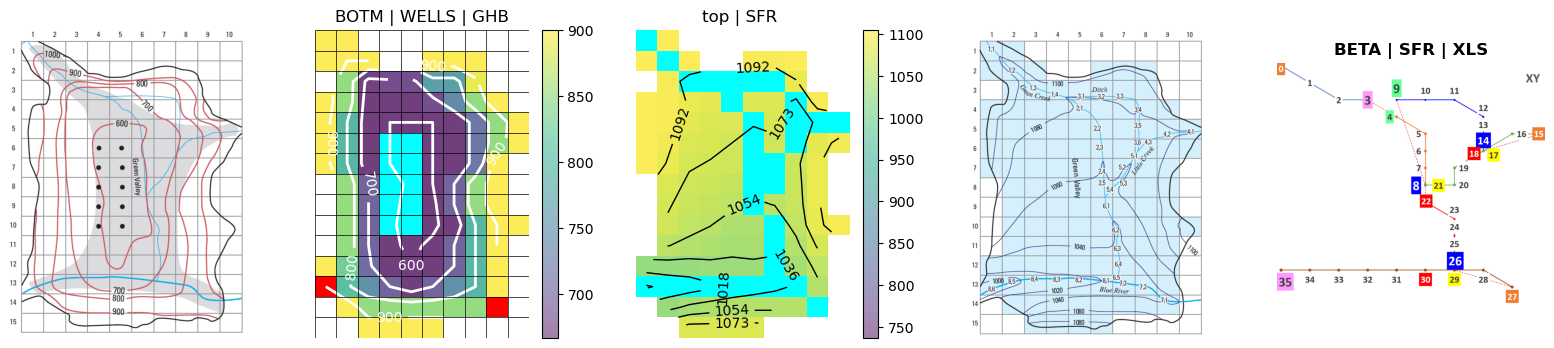

Diversion :  [[3, 0, 9, 'UPTO']]
WELs_OBS_F: {0: [[0, 5, 3, 0], [0, 5, 4, 0], [0, 6, 3, 0], [0, 6, 4, 0], [0, 7, 3, 0], [0, 7, 4, 0], [0, 8, 3, 0], [0, 8, 4, 0], [0, 9, 3, 0], [0, 9, 4, 0]], 1: [[0, 5, 3, -10.0], [0, 5, 4, -10.0], [0, 6, 3, -10.0], [0, 6, 4, -10.0], [0, 7, 3, -10.0], [0, 7, 4, -10.0], [0, 8, 3, -10.0], [0, 8, 4, -10.0], [0, 9, 3, -10.0], [0, 9, 4, -10.0]]}


In [5]:
fig = plt.figure(figsize=(20, 4), dpi=100)                                                               ; VMIN=np.max(botm[0])/1.5 ; VMAX=np.max(botm[0])*.9
ax = fig.add_subplot(151)            ; image=plt.imread(REF1/'SRF1.png')     ; ax.imshow(image) ;ax.axis('off')       
ax = fig.add_subplot(152)            ; mm=flopy.plot.PlotMapView(GWF,ax=ax)   ; CO=mm.plot_array(botm ,vmin=VMIN                 ,vmax=VMAX,masked_values=(0,1e30,-1e30),alpha=0.5) 
cbar=plt.colorbar(CO,ax=ax,format="%.0f")    ; plt.axis('off')               ; CW= mm.contour_array(botm,levels=LEV,linewidths=2,linestyles="-",colors="white",masked_values=(0, 1e30, -1e30)) 
mm.plot_bc("GHB", color="red")  ; mm.plot_bc("WEL",color="cyan",kper=1) ; ax.set_title("BOTM | WELLS | GHB")  ; mm.plot_grid(lw=0.5, color="black")  ; plt.clabel(CW, fmt="%1.0f")

ax = fig.add_subplot(153)            ; ax.set_title("top | SFR ")  ;plt.axis('off') ; # ______________________________________________________________________________________
mm=flopy.plot.PlotMapView(GWF,ax=ax)  ;TC=mm.plot_array(top,vmin=np.max(top[0])/1.5,vmax=np.max(top[0]),masked_values=(0,1e30,-1e30),alpha=0.5)       ; cbar=plt.colorbar(TC,ax=ax, format="%.0f")
mm.plot_bc("SFR", color="cyan") ; CV = mm.contour_array(top,levels=LT,linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))     ; plt.clabel(CV, fmt="%1.0f")

ax = fig.add_subplot(154)            ;image=plt.imread(REF1/'SRF2.png') ;ax.imshow(image) ;ax.axis('off')   
ax = fig.add_subplot(155)            ;image=plt.imread(REF1/'BXLS.png') ;ax.imshow(image) ;ax.axis('off')     ; ax.set_title("BETA | SFR | XLS",fontweight="bold") ; plt.show()

print('Diversion : ', SFR_D)   ; print('WELs_OBS_F:', WEL_S) #import xlwings as xw ; wb = xw.Book('E:/15_REPOS/02_Beta-Me/Beta_xls/11_15_51_SFR.xlsx')  ; wb.sheets['b'].activate()

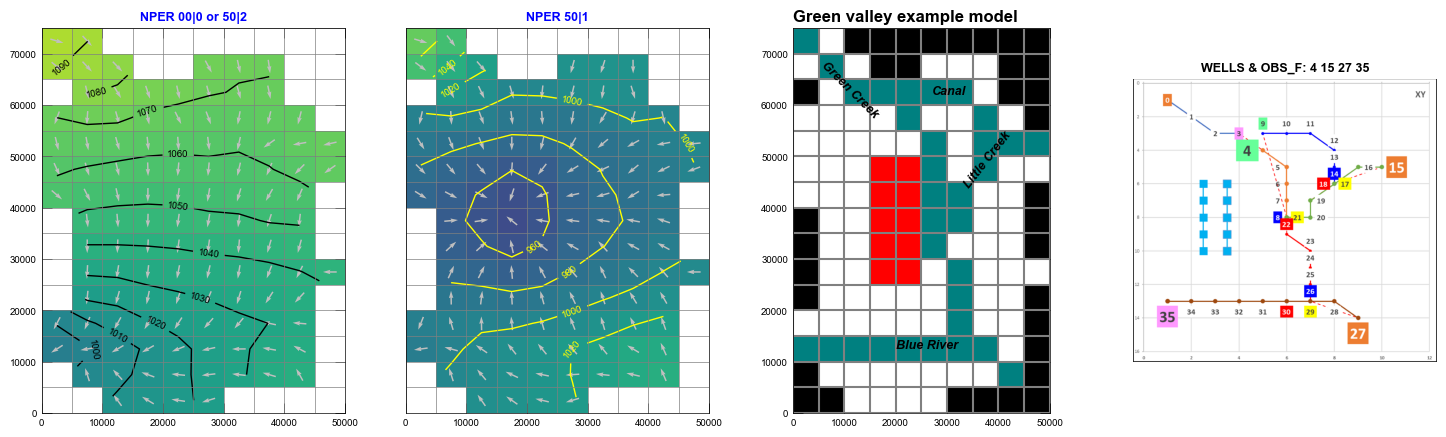

In [6]:
fig = plt.figure(figsize=(18, 5))     ;extents = (0.0,delr*ncol,0.0,delc*nrow)             # ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))
with styles.USGSMap():
    ax = fig.add_subplot(141)   # _______________________________________________________________________________________________________    
    mm=flopy.plot.PlotMapView(GWF,ax=ax,extent=extents)  ;HC=mm.plot_array(head0,vmin=900,vmax=1120,masked_values=(0,1e30,-1e30))     ;ax.set_title('NPER 00|0 or 50|2',fontweight='bold', color='blue')
    CV = mm.contour_array(head0,levels=np.arange(900, 1100, 10),linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
    plt.clabel(CV, fmt="%1.0f") ; mm.plot_vector(QX0, QY0, normalize=True, color="0.75")   ;mm.plot_grid(lw=0.5)  
    ax = fig.add_subplot(142)   # _______________________________________________________________________________________________________
    mn = flopy.plot.PlotMapView(GWF,ax=ax,extent=extents) ;HC=mn.plot_array(head1,vmin=900,vmax=1120,masked_values=(0, 1e30,-1e30))   ;ax.set_title('NPER 50|1',fontweight='bold',color='b')  
    CV = mn.contour_array(head1,levels=np.arange(900, 1100, 20),linewidths=1,linestyles="-",colors="yellow",masked_values=(0, 1e30, -1e30))
    plt.clabel(CV, fmt="%1.0f") ; mn.plot_vector(QX1, QY1, normalize=True, color="0.75")   ;mn.plot_grid(lw=0.5)                               ; ax.yaxis.set_visible(False) 
    ax = fig.add_subplot(143)
    pmv = flopy.plot.PlotMapView(GWF,) ; pmv.plot_inactive() ; pmv.plot_grid() ; pmv.plot_bc("SFR") ; pmv.plot_bc("WEL", plotAll=True,kper=1)
    styles.heading(ax=ax, heading="Green valley example model", fontsize=12)    
    styles.add_text(ax,text="Green Creek",x=0.10,y=0.76,bold=True,rotation=-45,fontsize=9,) ; styles.add_text(ax, text="Canal", x=0.54, y=0.82, bold=True, fontsize=9)
    styles.add_text(ax,text="Little Creek",x=0.66,y=0.58,bold=True,rotation=52,fontsize=9,) ; styles.add_text(ax, text="Blue River", x=0.40, y=0.16, bold=True, fontsize=9)
    ax = fig.add_subplot(144)   ; image=plt.imread(REF1/'BXLS_2.png') ;ax.imshow(image) ;ax.axis('off')         ; ax.set_title("WELLS & OBS_F: 4 15 27 35",fontweight="bold")   ;plt.show()

In [7]:
obs = GWF.sfr.output.obs()      ; df = obs.get_dataframe(start_datetime=dt.datetime(2024, 6, 1), timeunit="s")                     ; df.to_csv(TA/"_RES_01.csv") ; #df.head()
reach_info = {3: ("R01", "Upper Green Creek"),14: ("R02", "Little Creek"),26: ("R03", "Lower Green Creek"),35: ("R04", "Blue River"),} ; rtops = GWF.sfr.packagedata ; #rtops

In [8]:
TB=Path("./TA/TB");TB.mkdir(exist_ok=True)                                                    ;pd.DataFrame(os.listdir(TB)).to_csv(TB/"_01_LIST.csv")
np.savetxt(TB/"_01_SP.csv",SFR_P,delimiter=",");pd.DataFrame(SFR_C).to_csv(TB/"_02_SC.csv")   ;np.savetxt(TB/"_03_SD.csv",SFR_D,fmt="%s",delimiter=",");pd.DataFrame(SFR_S).to_csv(TB/"_04_SS.csv")
np.savetxt(TB/"_05_IDO.csv",idomain,delimiter=",") ;np.savetxt(TB/"_05_TOP.csv",top,delimiter=",");np.savetxt(TB/"_05_RCH.csv",recharge,delimiter=",")  ;np.savetxt(TB/"_05_SURF_W.csv",surf,delimiter=",")
np.savetxt(TB/"_05_GHB_spd.csv",GHB_S,delimiter=",")  ; pd.DataFrame(OBS_D).to_csv(TB/"_05_OBS_D.csv")  
with open(TB/"_06_WEL_spd.csv", "w", newline="") as ff:       # _____________________________________________ saving
    mm = csv.DictWriter(ff, WEL_S.keys())   ; mm.writeheader()  ; mm.writerow(WEL_S)

with open(TA/"_07_OBS_F.csv", 'w', newline='')   as csvfile:  # _____________________________________________ saving
    writer = csv.writer(csvfile)
n='n'                                                                          ; SFR_P = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).values.tolist()   # Bxls_sfr_P.csv
df = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')  ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()                         # Bxls_sfr_C.csv
n='n'                                                                          ; SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).values.tolist()   # Bxls_sfr_S.csv

**The Scenario:** Green Valley Water wants to begin pumping <font color='blue'> **10 public supply wells** </font> near Green Creek at the <font color='blue'> **rate of 10 cu-ft/s.** </font> However, Green Creek provides import spawing habitat for a population of California Golden Trout that primarily lives in Blue River. It's been noted that 
<font color='red'> **stream levels dropping to less than 5" or about 0.42 ft could have negative impacts on the trout population.** </font>

<font color='blue'> **The task: ___ find a sustainable long term pumping rates while maintaining in stream flows.** </font>

In [9]:
rtops = GWF.sfr.packagedata.array["rtp"]        ; RAS = pd.DataFrame(GWF.sfr.output.obs().data)
for rno, (rtag, name) in reach_info.items():
    new_col = f"{rtag}_depth"
    stage_col = f"{rtag}_STAGE"
    rtop = rtops[rno]
    RAS[new_col] = RAS[stage_col] - rtop

RAS.head()

,totim,R01_STAGE,R02_STAGE,R03_STAGE,R04_STAGE,R01_FLOW,R02_FLOW,R03_FLOW,R04_FLOW,R01_depth,R02_depth,R03_depth,R04_depth
0,0.000000e+00,1078.985710,1061.581,1026.938536,993.398198,-36.023592,-4.453959,-18.963507,-169.415864,1.577710,1.036,1.029536,1.523198
1,1.355674e+06,1078.985652,1061.581,1026.924784,993.395890,-36.019027,-4.445658,-18.548147,-168.989651,1.577652,1.036,1.015784,1.520890
2,2.846914e+06,1078.985460,1061.581,1026.898299,993.391190,-36.003868,-4.415830,-17.758699,-168.122471,1.577460,1.036,0.989299,1.516190
3,4.487279e+06,1078.985055,1061.581,1026.859635,993.384075,-35.972159,-4.349762,-16.631285,-166.812122,1.577055,1.036,0.950635,1.509075
4,6.291681e+06,1078.984377,1061.581,1026.815182,993.375493,-35.919486,-4.234304,-15.372294,-165.236016,1.576377,1.036,0.906182,1.500493


In [10]:
THR = 0.43
idxs = np.where(RAS["R03_depth"].values < THR)[0]   ; idx = list(sorted(idxs))[0]    ; RAS2 = RAS.reset_index()  ; RAS3 = pd.DataFrame(RAS2.iloc[idx])       # H27_depth
years_pumped = (RAS2.loc[idx, "totim"] - RAS2.loc[0, "totim"]) / (365.25 * 86400)       ; print(f"{years_pumped = :.2f}")    # ; RES3.T  

years_pumped = 1.36


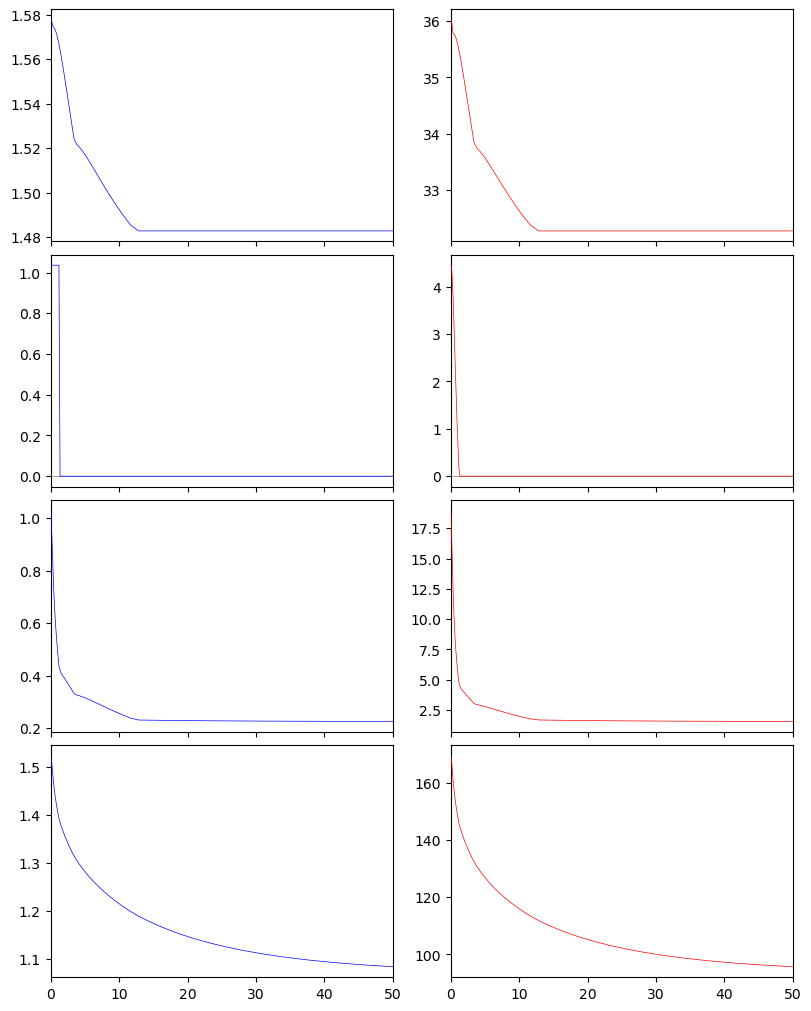

In [11]:
rnames = {3: "Upper Green Creek",14: "Little Creek",26: "Lower Green Creek",35: "Blue River",}
RES = GWF.sfr.output.obs().data     ; RES["totim"] /= 365.25 * 86400.0  ; RNOS = (3,14,26,35,)  ; sfr = GWF.sfr.packagedata.array["rtp"]    ; 
offsets = []
for RR in RNOS:                   offsets.append(sfr[RR])
fig, axes = plt.subplots(ncols=2,nrows=4,sharex=True,figsize=(8, 10),constrained_layout=True,)        ; ipos = 0
for i in range(4):  
    rname = rnames[RNOS[i]]  ; heading = f"{rname}"
    for j in range(2):
        ax = axes[i, j] ; ax.set_xlim(0, 50)
        if j == 0:  tag = f"R{i + 1:02d}_STAGE"     ;offset = offsets[i]    ;scale = 1.0    ;ylabel = "Depth, ft"       ; color = "blue" 
        else:       tag = f"R{i + 1:02d}_FLOW"      ;offset = 0.0           ;scale = -1.0   ;ylabel = "Flow , ft3_sec"  ; color = "red"
        
        ax.plot(RES["totim"],       scale * RES[tag] - offset,lw=0.5,color=color,zorder=10,)
        if ax.get_ylim()[0] < 0.0:                  ax.axhline(0, lw=0.5, color="0.5", zorder=9)
            
plt.show()


In [12]:
_DLL_PATH= Path(os.getenv("CONDA_PREFIX"))                     ; _DLL_PATH=_DLL_PATH / "Scripts"  ; libmf6 = (_DLL_PATH / f"libmf6.dll").resolve() ; 
mf6 = modflowapi.ModflowApi(libmf6, working_directory=TA)    ; mf6.initialize()                 ; dt     = mf6.get_time_step()       ; mf6.prepare_time_step(dt)     
ivn = mf6.get_input_var_names()     ; sfr_vars = [i for i in ivn if "SFR_0" in i]                 ; print(sfr_vars)                    ; sfr_var_interest = []
for i in sfr_vars: 
    if "OUTFLOW" in i or "STAGE" in i or "STRTOP" in i:        sfr_var_interest.append(i)                                              # OUTFLOW | STAGE_H | STR_TOP
mf6.finalize()                                               ; print('NPER:',kstpkper)            # print(sfr_var_interest)

['GREEN_VALLEY/SFR_0/INPUT_FNAME', 'GREEN_VALLEY/SFR_0/PACKAGE_TYPE', 'GREEN_VALLEY/SFR_0/ID', 'GREEN_VALLEY/SFR_0/INUNIT', 'GREEN_VALLEY/SFR_0/IOUT', 'GREEN_VALLEY/SFR_0/INEWTON', 'GREEN_VALLEY/SFR_0/IASYM', 'GREEN_VALLEY/SFR_0/IPRPAK', 'GREEN_VALLEY/SFR_0/IPRFLOW', 'GREEN_VALLEY/SFR_0/IPAKCB', 'GREEN_VALLEY/SFR_0/IONPER', 'GREEN_VALLEY/SFR_0/LASTONPER', 'GREEN_VALLEY/SFR_0/LISTLABEL', 'GREEN_VALLEY/SFR_0/ISADVPAK', 'GREEN_VALLEY/SFR_0/IBCNUM', 'GREEN_VALLEY/SFR_0/MAXBOUND', 'GREEN_VALLEY/SFR_0/NBOUND', 'GREEN_VALLEY/SFR_0/NCOLBND', 'GREEN_VALLEY/SFR_0/ISCLOC', 'GREEN_VALLEY/SFR_0/NAUX', 'GREEN_VALLEY/SFR_0/INAMEDBOUND', 'GREEN_VALLEY/SFR_0/IAUXMULTCOL', 'GREEN_VALLEY/SFR_0/INOBSPKG', 'GREEN_VALLEY/SFR_0/IMOVER', 'GREEN_VALLEY/SFR_0/IVSC', 'GREEN_VALLEY/SFR_0/NPAKEQ', 'GREEN_VALLEY/SFR_0/IOFFSET', 'GREEN_VALLEY/SFR_0/AUXNAME', 'GREEN_VALLEY/SFR_0/AUXNAME_CST', 'GREEN_VALLEY/SFR_0/IPRHED', 'GREEN_VALLEY/SFR_0/ISTAGEOUT', 'GREEN_VALLEY/SFR_0/IBUDGETOUT', 'GREEN_VALLEY/SFR_0/IBUDCSV', 'G

In [13]:
%%capture 
def PUMPING_API_SAME(sim, callback_step):  
    irch = 26  ; threshold = THR  ; ic_pumping = -10  ; ml = sim.get_model()                # 26 ____  downstream green creek observation location
    if callback_step == Callbacks.initialize:           print(sim.models)
    if callback_step == Callbacks.timestep_start:
        if sim.kper > 0:             ml.wel.stress_period_data["q"] = np.full((10,), ic_pumping)
    if callback_step == Callbacks.iteration_start:
        if sim.kper > 0:
            if sim.iteration == 0:  sim.allow_convergence = False   ;return
        sfr = ml.sfr            ; STAGE = sfr.get_advanced_var("stage")     ; STRTOP = sfr.get_advanced_var("strtop")       ; depth = STAGE[irch] - STRTOP[irch]
        if depth < threshold:     sim.allow_convergence = False             ; pumping = ml.wel.stress_period_data["q"]
        else:                     sim.allow_convergence = True
modflowapi.run_simulation(libmf6, sim_ws, PUMPING_API_SAME, verbose=True)

In [14]:
#plot_sfr_results(GWF)

In [15]:
conv = 365.25 * 86400.0  ; cbc = GWF.output.budget()   ; wels = cbc.get_data(text="WEL")[1:]             ; totim = np.array(cbc.times[1:])     ; times = totim - totim[0]  
pumping = np.array([r["q"][0] for r in wels])          ; df = pd.DataFrame(data=np.array([times, pumping]).T, columns=["time", "pumping"])     ; df["time"] /= conv #; df.tail()   # ; wels

In [16]:
def adjust_pumping_callback_rampdown(sim, callback_step):
    irch = 26  ; threshold = 0.43  ; ic_pumping = -10   ; ml = sim.get_model()
    if callback_step == Callbacks.initialize:               print(sim.models)
    if callback_step == Callbacks.timestep_start:
        if sim.kper > 0:    ml.wel.stress_period_data["q"] = np.full((10,), ic_pumping)
    if callback_step == Callbacks.iteration_start:
        if sim.kper > 0:
            if sim.iteration == 0:
                sim.allow_convergence = False
                return
            sfr = ml.sfr                ; stages = sfr.get_advanced_var("stage")    ; strtops = sfr.get_advanced_var("strtop") 
            gr_stage = stages[irch]     ; gr_strtop = strtops[irch]                 ; depth = stages[irch] - strtops[irch]
            if depth <= threshold:
                sim.allow_convergence = False   ; spd = ml.wel.stress_period_data
                if abs(spd["q"][0]) <= 0.1:     spd["q"] = 0
                else:                           ml.wel.stress_period_data["q"] *= 0.90
            else:                   sim.allow_convergence = True

In [17]:
%%capture 
modflowapi.run_simulation(libmf6, sim_ws, adjust_pumping_callback_rampdown, verbose=False)

In [18]:
RES2 = GWF.sfr.output.obs().data     ; RES2["totim"] /= 365.25 * 86400.0  ; RNOS = (3,14,26,35,)  ; sfr2 = GWF.sfr.packagedata.array["rtp"]
def plot_sfr_results2(gwf, silent=True):     
    rnames = {3: "Upper Green Creek",14: "Little Creek",26: "Lower Green Creek",35: "Blue River",}
    with styles.USGSPlot():
            
        offsets = []
        for RR in RNOS:                   offsets.append(sfr2[RR])
        fig, axes = plt.subplots(ncols=2,nrows=4,sharex=True,figsize=(8, 10),constrained_layout=True,)        ; ipos = 0
        for i in range(4):  
            rname = rnames[RNOS[i]]  ; heading = f"{rname}"
            for j in range(2):
                ax = axes[i, j] ; ax.set_xlim(0, 50)
                if j == 0:  tag = f"R{i + 1:02d}_STAGE"     ;offset = offsets[i]    ;scale = 1.0    ;ylabel = "Depth, ft"       ; color = "blue" 
                else:       tag = f"R{i + 1:02d}_FLOW"      ;offset = 0.0           ;scale = -1.0   ;ylabel = "Flow , ft3_sec"  ; color = "red"
                
                ax.plot(RES2["totim"],scale * RES2[tag] - offset,lw=0.5,color=color,zorder=10,)
                if ax.get_ylim()[0] < 0.0:                  ax.axhline(0, lw=0.5, color="0.5", zorder=9)
                
                styles.add_text(ax,text="Pumping",x=0.49,y=0.8,ha="right",bold=False,fontsize=7,)   ; ax.set_ylabel(ylabel) ; ax.yaxis.set_label_coords(-0.1, 0.5)
                
                styles.heading(ax, heading=heading, idx=ipos)
                if i == 3:  ax.set_xlabel("Time since pumping began, in years")
                ipos += 1
        plt.show()
#plot_sfr_results(GWF)

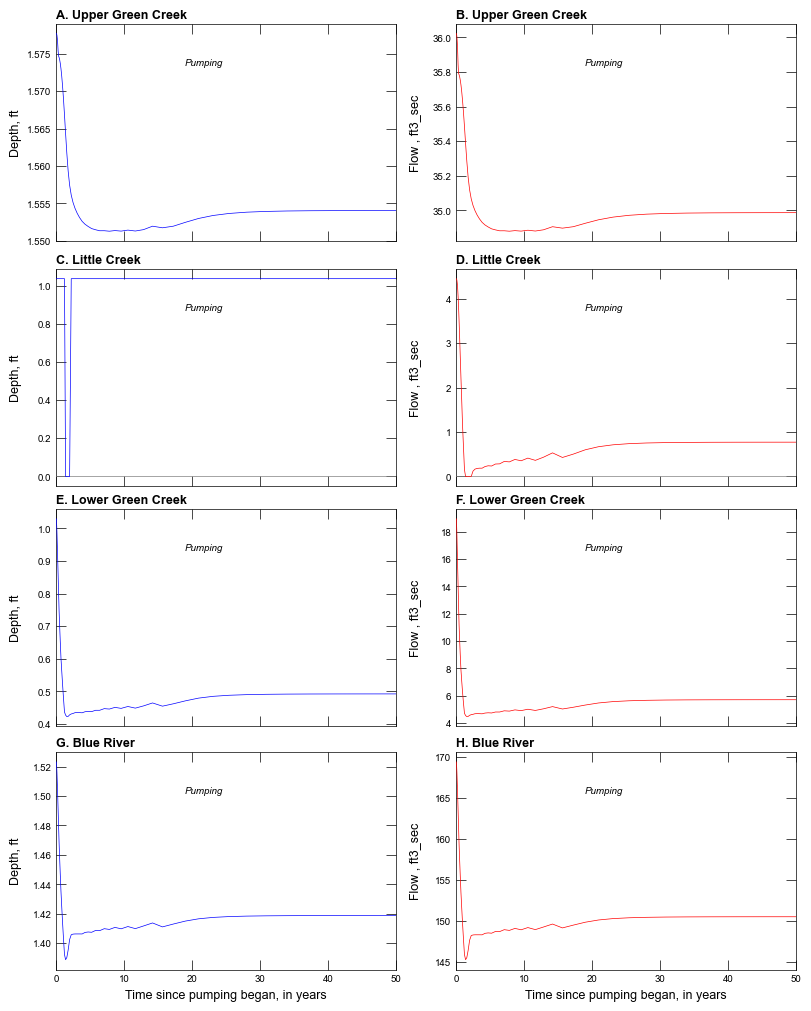

In [19]:
plot_sfr_results2(GWF)

In [20]:
conv = 365.25 * 86400.0         ; cbc = GWF.output.budget()     ; wels = cbc.get_data(text="WEL")[1:]   ; totim = np.array(cbc.times[1:])       ; times = totim - totim[0]
pumping = np.array([r["q"][0] for r in wels])                   ; print(pumping)

[-10.         -10.         -10.         -10.         -10.
 -10.         -10.         -10.         -10.         -10.
 -10.         -10.         -10.         -10.           0.
   0.           0.           0.          -5.31441     -4.782969
  -3.87420489  -3.87420489  -3.87420489  -3.87420489  -3.4867844
  -3.87420489  -3.87420489  -3.4867844   -3.87420489  -3.4867844
  -3.87420489  -3.4867844   -3.87420489  -3.4867844   -3.87420489
  -3.4867844   -3.4867844   -3.87420489  -3.4867844   -3.4867844
  -3.4867844   -3.4867844   -3.4867844   -3.4867844   -3.4867844
  -3.4867844   -3.4867844   -3.4867844   -3.4867844   -3.4867844 ]


In [21]:
# put this in a pandas dataframe, becasue something weird was going on with notebooks
df = pd.DataFrame(
    data=np.array([times, pumping]).T, columns=["time", "pumping"]
)
df["time"] /= conv
df.tail()

,time,pumping
45,33.971541,-3.486784
46,37.415949,-3.486784
47,41.204799,-3.486784
48,45.372533,-3.486784
49,49.957041,-3.486784


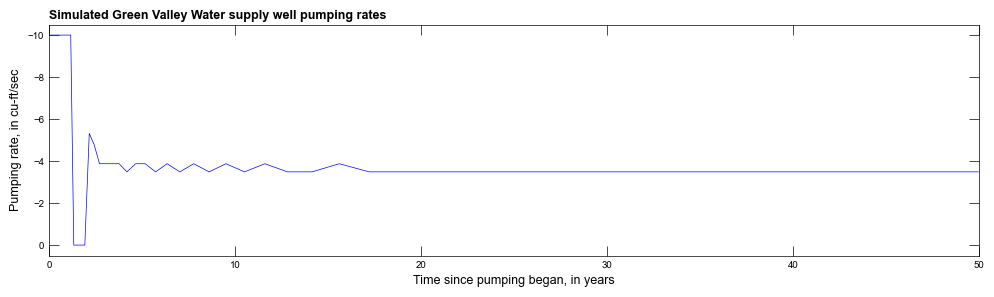

In [24]:
with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(0, 50)
    ax.set_ylim(0.5, -10.5)
    ax.plot(df.time.values, df.pumping.values, lw=0.5, color="blue")
    ax.set_ylabel("Pumping rate, in cu-ft/sec")
    ax.set_xlabel("Time since pumping began, in years")
    styles.heading(
        ax, heading="Simulated Green Valley Water supply well pumping rates"
    )
    plt.show()